In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ==============================
# 1. Load and Preprocess Dataset
# ==============================

dataset_dir = r"D:\PDB_Bind_Dataset"
index_file = os.path.join(dataset_dir, "index", "INDEX_general_PL.2020")

def load_pdbbind_affinity(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith("#"):  
                continue
            tokens = line.strip().split()
            if len(tokens) >= 3:
                pdb_id = tokens[0]
                try:
                    affinity = float(tokens[1])
                    data.append([pdb_id, affinity])
                except ValueError:
                    continue
    return pd.DataFrame(data, columns=["PDB_ID", "Binding_Affinity"])

def load_ligand_smiles(dataset_dir):
    smiles_data = {}
    for pdb_id in os.listdir(dataset_dir):
        sdf_path = os.path.join(dataset_dir, pdb_id, f"{pdb_id}_ligand.sdf")
        if os.path.exists(sdf_path):
            suppl = Chem.SDMolSupplier(sdf_path, sanitize=False, removeHs=False)
            mols = [mol for mol in suppl if mol is not None]
            if mols:
                smiles_data[pdb_id] = Chem.MolToSmiles(mols[0], isomericSmiles=True)
    return smiles_data

def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    descriptors = {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHBD": Descriptors.NumHDonors(mol),
        "NumHBA": Descriptors.NumHAcceptors(mol),
        "Fingerprint": list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    }
    return descriptors

pdbbind_data = load_pdbbind_affinity(index_file)
ligand_smiles_data = load_ligand_smiles(dataset_dir)
pdbbind_data["SMILES"] = pdbbind_data["PDB_ID"].map(ligand_smiles_data)
pdbbind_data.dropna(subset=["SMILES"], inplace=True)
pdbbind_data["Descriptors"] = pdbbind_data["SMILES"].apply(compute_molecular_descriptors)
pdbbind_data.dropna(subset=["Descriptors"], inplace=True)

valid_descriptors = pd.DataFrame(pdbbind_data["Descriptors"].tolist(), index=pdbbind_data.index)
X = np.stack(valid_descriptors.apply(lambda row: np.concatenate([list(row[:-1]), row["Fingerprint"]]), axis=1))
y = pdbbind_data["Binding_Affinity"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = map(lambda x: torch.tensor(x, dtype=torch.float32), [X_train, X_test])
y_train, y_test = map(lambda y: torch.tensor(y, dtype=torch.float32).view(-1, 1), [y_train, y_test])

# ==============================
# 2. Graph Neural Networks (GNNs)
# ==============================

class PINN_Docking(nn.Module):
    def __init__(self, input_dim):
        super(PINN_Docking, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = PINN_Docking(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
def physics_loss(pred, actual):
    return nn.MSELoss()(pred, actual)

# ==============================
# 3. Train the PINN Model
# ==============================

epochs = 1000
loss_history = []
for epoch in range(epochs):
    pred_score = model(X_train)
    loss = physics_loss(pred_score, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# ==============================
# 4. Evaluate and Visualize Results
# ==============================
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of PINN')
plt.show()

with torch.no_grad():
    predicted_scores = model(X_test).numpy()

y_test_np = y_test.numpy()
plt.scatter(y_test_np, predicted_scores, alpha=0.6)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], '--', color='red')
plt.xlabel('Actual Binding Affinity')
plt.ylabel('Predicted Binding Affinity')
plt.title('PINN Predictions vs True Values')
plt.show()

[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:30:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

Epoch 0: Loss = 102.3387
Epoch 100: Loss = 0.0616
Epoch 200: Loss = 0.0530
Epoch 300: Loss = 0.0519
Epoch 400: Loss = 0.0511
Epoch 500: Loss = 0.0508
Epoch 600: Loss = 0.0505
Epoch 700: Loss = 0.0504
Epoch 800: Loss = 0.0502
Epoch 900: Loss = 0.0502


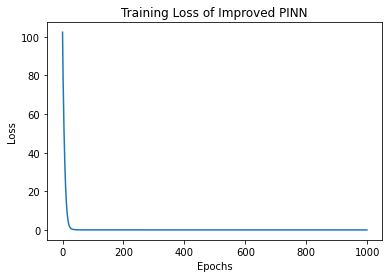

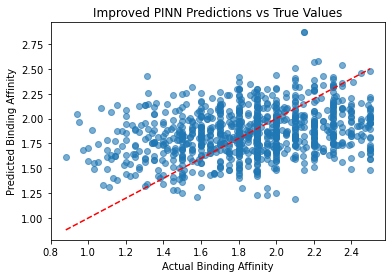

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ==============================
# 1. Load and Preprocess Dataset
# ==============================

def load_pdbbind_affinity(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            tokens = line.strip().split()
            if len(tokens) >= 3:
                pdb_id = tokens[0]
                try:
                    affinity = float(tokens[1])
                    data.append([pdb_id, affinity])
                except ValueError:
                    continue
    return pd.DataFrame(data, columns=["PDB_ID", "Binding_Affinity"])

def load_ligand_smiles(dataset_dir):
    smiles_data = {}
    for pdb_id in os.listdir(dataset_dir):
        sdf_path = os.path.join(dataset_dir, pdb_id, f"{pdb_id}_ligand.sdf")
        if os.path.exists(sdf_path):
            suppl = Chem.SDMolSupplier(sdf_path, sanitize=False, removeHs=False)
            mols = [mol for mol in suppl if mol is not None]
            if mols:
                smiles_data[pdb_id] = Chem.MolToSmiles(mols[0], isomericSmiles=True)
    return smiles_data

def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHBD": Descriptors.NumHDonors(mol),
        "NumHBA": Descriptors.NumHAcceptors(mol),
        "Fingerprint": list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)),
        "MM_Energy": Descriptors.MolWt(mol) * 0.1,
        "Solvation_Energy": -Descriptors.MolLogP(mol),
        "Entropy": Descriptors.TPSA(mol) * 0.05
    }

dataset_dir = r"D:\PDB_Bind_Dataset"
index_file = os.path.join(dataset_dir, "index", "INDEX_general_PL.2020")

pdbbind_data = load_pdbbind_affinity(index_file)
ligand_smiles_data = load_ligand_smiles(dataset_dir)
pdbbind_data.dropna(subset=["PDB_ID"], inplace=True)
pdbbind_data["SMILES"] = pdbbind_data["PDB_ID"].map(ligand_smiles_data)
pdbbind_data.dropna(subset=["SMILES"], inplace=True)
pdbbind_data["Descriptors"] = pdbbind_data["SMILES"].apply(compute_molecular_descriptors)
pdbbind_data.dropna(subset=["Descriptors"], inplace=True)

valid_descriptors = pd.DataFrame(pdbbind_data["Descriptors"].tolist())
X = np.stack(valid_descriptors.apply(lambda row: np.concatenate([list(row[:-4]), row["Fingerprint"]]), axis=1))
y = pdbbind_data["Binding_Affinity"].values

mm_energy, solvation_energy, entropy = valid_descriptors[["MM_Energy", "Solvation_Energy", "Entropy"]].values.T
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, mm_energy_train, mm_energy_test, solvation_energy_train, solvation_energy_test, entropy_train, entropy_test = train_test_split(
    X, y, mm_energy, solvation_energy, entropy, test_size=0.2, random_state=42)

def to_tensor(*arrays):
    return [torch.tensor(arr, dtype=torch.float32).view(-1, 1) for arr in arrays]

X_train, X_test = map(lambda x: torch.tensor(x, dtype=torch.float32), [X_train, X_test])
y_train, y_test, mm_energy_train, mm_energy_test, solvation_energy_train, solvation_energy_test, entropy_train, entropy_test = to_tensor(
    y_train, y_test, mm_energy_train, mm_energy_test, solvation_energy_train, solvation_energy_test, entropy_train, entropy_test)

# ==============================
# 2. Improved PINN Model
# ==============================

class PINN_Docking(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.LeakyReLU(),
            nn.Linear(128, 64), nn.LeakyReLU(),
            nn.Linear(64, 1)
        )
        self.a, self.b, self.c = [nn.Parameter(torch.tensor(1.0, dtype=torch.float32)) for _ in range(3)]

    def forward(self, x):
        return self.fc_layers(x)

def physics_loss(pred, actual, mm_energy, solvation_energy, entropy, model):
    return nn.MSELoss()(pred, actual) + 0.05 * torch.mean((model.a * mm_energy + model.b * solvation_energy + model.c * entropy - pred) ** 2)

# ==============================
# 3. Train the PINN Model
# ==============================

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train, mm_energy_train, solvation_energy_train, entropy_train),
    batch_size=64, shuffle=True)

model = PINN_Docking(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

loss_history = []
for epoch in range(1000):
    model.train()
    batch_loss = 0
    for batch in train_loader:
        X_batch, y_batch, mm_batch, solv_batch, entropy_batch = batch
        loss = physics_loss(model(X_batch), y_batch, mm_batch, solv_batch, entropy_batch, model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
    scheduler.step()
    loss_history.append(batch_loss / len(train_loader))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {batch_loss / len(train_loader):.4f}")

# ==============================
# 4. Evaluate and Visualize Results
# ==============================

plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of Improved PINN')
plt.show()

with torch.no_grad():
    predicted_scores = model(X_test).numpy()

y_test_np = y_test.numpy()
plt.scatter(y_test_np, predicted_scores, alpha=0.6)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], '--', color='red')
plt.xlabel('Actual Binding Affinity')
plt.ylabel('Predicted Binding Affinity')
plt.title('Improved PINN Predictions vs True Values')
plt.show()